In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Clean stuff

In [2]:
!rm -rf /kaggle/working/*

# Import libraries and Customize Parameters

In [3]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 14.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import torch

sns.set_style('darkgrid')

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))
# Set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is on: {device}')

Is CUDA available?  True
Device name:  Tesla P100-PCIE-16GB
Device is on: cuda


# Visualize simple images with annotations

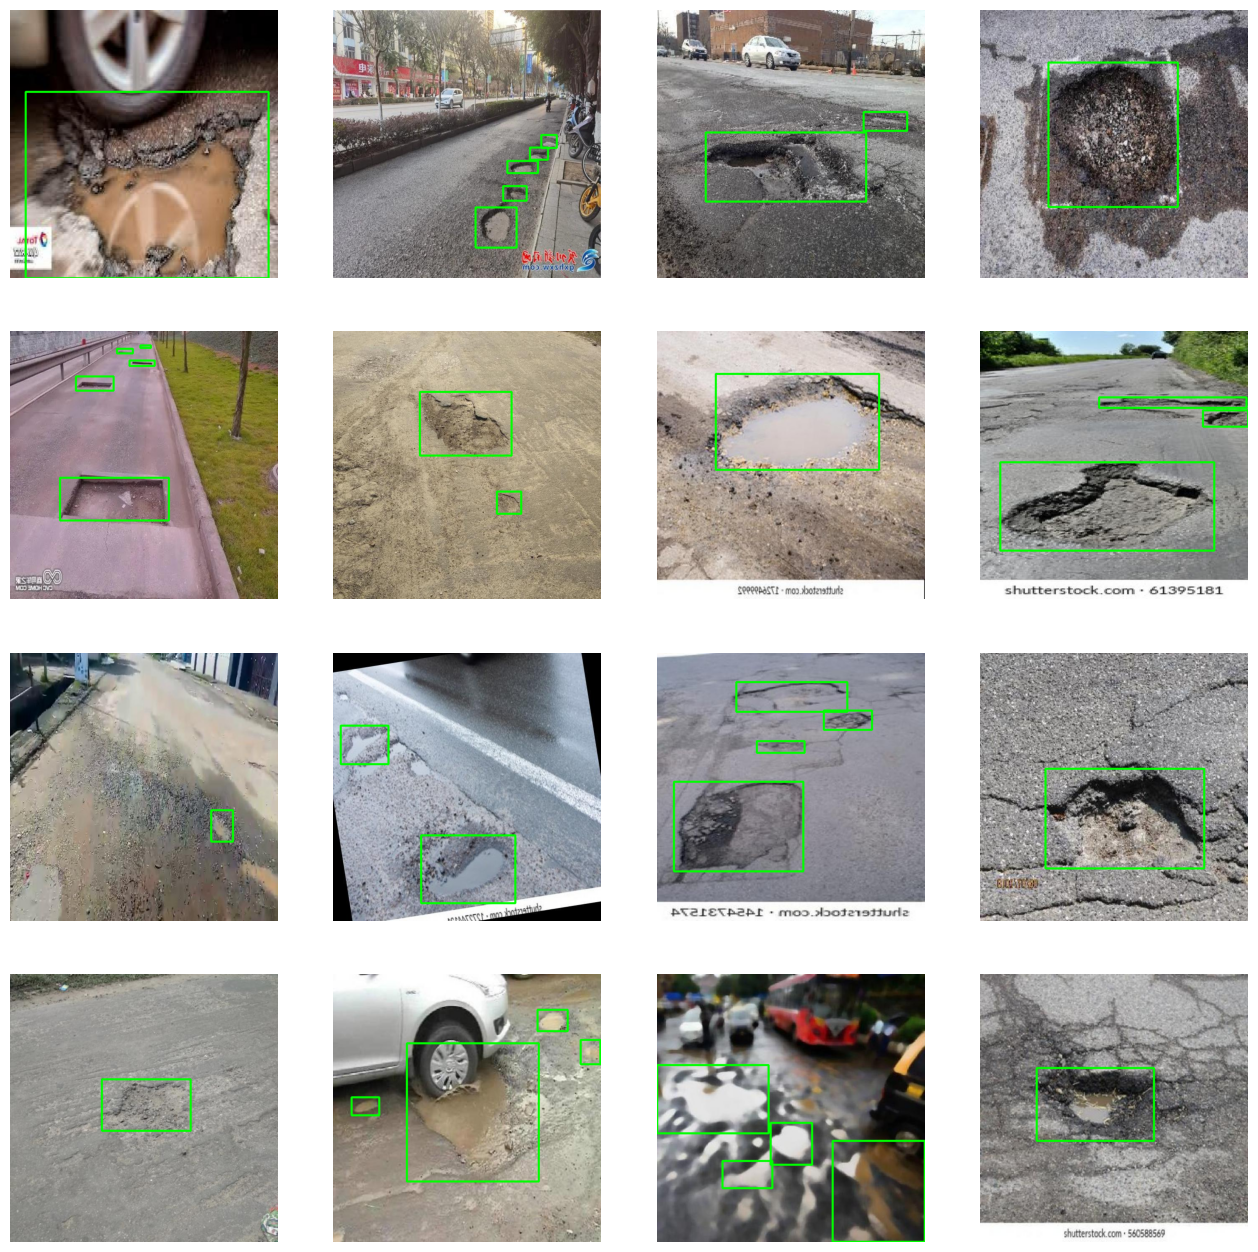

In [6]:
# Define the paths to the images and labels directories
train_images = "/kaggle/input/pothole-dataset/train/images"
train_labels = "/kaggle/input/pothole-dataset/train/labels"

test_images = "/kaggle/input/pothole-dataset/test/images"
test_labels = "/kaggle/input/pothole-dataset/test/images"

val_images = "/kaggle/input/pothole-dataset/valid/images"
val_labels = "/kaggle/input/pothole-dataset/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Show image metadata

In [7]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/pothole-dataset/test/images/0004_jpg.rf.f92ab952cd8544f887caf35fcccbcd10.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 640x640 and 3 channels.


# Model Training

In [8]:
# Loading a pretrained model
model = YOLO('yolo11n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
model.train(data = '/kaggle/input/pothole-dataset/data.yaml',
            epochs = 100,
            #patience = 10,
            imgsz = (height, width, channels)
            #seed = 42,
            #batch = 8,
            #workers = 4
           )

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.2MB/s]


Ultralytics 8.3.34 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/pothole-dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=(640, 640, 3), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]
2024-11-21 10:59:16,902	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-21 10:59:17,366	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/pothole-dataset/train/labels... 11068 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11068/11068 [00:33<00:00, 330.53it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3815, len(boxes) = 29161. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/pothole-dataset/valid/labels... 1808 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1808/1808 [00:04<00:00, 376.97it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.65G      1.682      2.394       1.57         26        640: 100%|██████████| 692/692 [02:31<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:12<00:00,  4.53it/s]


                   all       1808       4487       0.56      0.457      0.467      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.62G      1.676      1.795      1.529         35        640: 100%|██████████| 692/692 [02:26<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.39it/s]


                   all       1808       4487      0.547      0.451       0.45      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.68G      1.749       1.77      1.596         59        640: 100%|██████████| 692/692 [02:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.25it/s]


                   all       1808       4487      0.482      0.413      0.385      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.69G      1.804        1.8      1.655         38        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.54it/s]


                   all       1808       4487      0.592      0.444       0.47      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.68G      1.745      1.692      1.616         24        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.60it/s]


                   all       1808       4487      0.451      0.342      0.326      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.68G      1.703      1.624       1.59         69        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.57it/s]


                   all       1808       4487      0.575      0.475      0.503      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.68G      1.679      1.574      1.579         68        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


                   all       1808       4487      0.628      0.549      0.577       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.66G      1.657      1.535      1.564        109        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


                   all       1808       4487      0.665      0.535      0.593      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.69G      1.628      1.497      1.553         55        640: 100%|██████████| 692/692 [02:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.48it/s]


                   all       1808       4487      0.639      0.547      0.588      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.68G       1.63      1.491      1.552         68        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.43it/s]


                   all       1808       4487      0.676      0.554      0.615      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.67G       1.61      1.447      1.523         62        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.50it/s]


                   all       1808       4487      0.682       0.58      0.636      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.65G      1.587       1.41      1.506         45        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.56it/s]


                   all       1808       4487      0.682      0.561      0.624      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.62G      1.589      1.407      1.507         45        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.54it/s]


                   all       1808       4487      0.713      0.583       0.65      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.67G      1.571      1.383      1.506         49        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.67it/s]


                   all       1808       4487      0.702      0.604      0.665      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.68G      1.566      1.364      1.498         95        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.60it/s]


                   all       1808       4487      0.695      0.567      0.637      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.67G      1.539      1.345      1.481         43        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


                   all       1808       4487      0.705      0.623      0.677      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.67G      1.533      1.324       1.47         45        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


                   all       1808       4487       0.73      0.625      0.699      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.67G      1.536      1.321      1.474         93        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.56it/s]


                   all       1808       4487      0.728      0.616      0.683      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.67G      1.529      1.315       1.47         33        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


                   all       1808       4487      0.716      0.629      0.693      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.67G      1.508       1.29      1.456         59        640: 100%|██████████| 692/692 [02:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]


                   all       1808       4487      0.747      0.631      0.707      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.65G      1.505      1.277      1.456         51        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.45it/s]


                   all       1808       4487      0.746      0.632      0.711      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.65G      1.492      1.274       1.45         44        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.52it/s]


                   all       1808       4487      0.736      0.649       0.72      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.65G      1.489      1.246       1.44         48        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.51it/s]


                   all       1808       4487      0.733      0.655      0.716      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.67G      1.493      1.244      1.441         51        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.67it/s]


                   all       1808       4487       0.76      0.649       0.73      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.65G      1.483      1.241      1.438         44        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]


                   all       1808       4487      0.763      0.655      0.738      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.66G      1.469      1.225      1.434         36        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.73it/s]


                   all       1808       4487      0.763      0.662       0.74      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.67G      1.464      1.226      1.434         58        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.51it/s]


                   all       1808       4487      0.761      0.666      0.743      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.62G      1.455      1.206      1.417         28        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


                   all       1808       4487      0.765       0.69      0.757      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.62G      1.456      1.204      1.417         57        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.61it/s]


                   all       1808       4487      0.767      0.671      0.746      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.65G      1.443      1.188      1.407         60        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.68it/s]


                   all       1808       4487      0.794      0.676      0.765      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.68G       1.45      1.184      1.406         48        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.80it/s]

                   all       1808       4487      0.785      0.685      0.764      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.6G      1.436      1.171      1.395         40        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


                   all       1808       4487      0.802      0.683      0.767      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.67G      1.428      1.157      1.386         71        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]

                   all       1808       4487      0.776        0.7      0.774      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.67G      1.426      1.154      1.393         43        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.42it/s]


                   all       1808       4487      0.788       0.69      0.771      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.62G      1.411       1.14      1.385         52        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.55it/s]


                   all       1808       4487      0.781      0.707      0.774      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.67G      1.409      1.134      1.382         38        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


                   all       1808       4487      0.801      0.706       0.79      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.68G      1.408       1.13      1.381         57        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.75it/s]

                   all       1808       4487      0.788      0.712      0.785      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.68G      1.399      1.115      1.376         60        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]

                   all       1808       4487       0.79      0.713      0.785      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.68G       1.39      1.106      1.364         24        640: 100%|██████████| 692/692 [02:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.43it/s]


                   all       1808       4487        0.8      0.708      0.787      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.65G      1.395      1.115      1.369         42        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.54it/s]


                   all       1808       4487      0.804      0.706       0.79      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.65G      1.384      1.105      1.367         34        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.27it/s]


                   all       1808       4487      0.812      0.701       0.79      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.67G       1.38      1.097      1.361         44        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.76it/s]

                   all       1808       4487      0.819      0.702      0.797      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.67G      1.371      1.078      1.348         57        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]

                   all       1808       4487      0.818      0.723      0.797      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.65G       1.37      1.076      1.351         51        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.43it/s]

                   all       1808       4487      0.815      0.724      0.804       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.62G      1.357      1.069      1.351         30        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.69it/s]

                   all       1808       4487      0.817      0.731      0.803      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.67G      1.355      1.057      1.338         39        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.65it/s]

                   all       1808       4487      0.825      0.723      0.806      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.68G      1.358       1.06      1.345         30        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.32it/s]


                   all       1808       4487      0.812      0.729      0.808      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.67G      1.353      1.054      1.339         68        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.69it/s]


                   all       1808       4487      0.826      0.723      0.811      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.67G       1.34      1.039      1.329         62        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.73it/s]

                   all       1808       4487      0.826      0.729       0.81      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.62G      1.345      1.039       1.33         37        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.67it/s]


                   all       1808       4487      0.833      0.729      0.814      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.65G      1.334      1.024      1.321         56        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.43it/s]


                   all       1808       4487      0.837      0.739      0.817      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.65G      1.331       1.02      1.317         45        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.53it/s]

                   all       1808       4487      0.846      0.732      0.821      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.65G      1.331      1.017      1.321        102        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


                   all       1808       4487      0.841      0.738       0.82      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.63G      1.327      1.014      1.314         60        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]

                   all       1808       4487      0.846       0.73      0.821      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.65G      1.313      1.004      1.312         53        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.73it/s]

                   all       1808       4487      0.847      0.732      0.821      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.68G      1.311     0.9951      1.306         61        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.80it/s]

                   all       1808       4487      0.848      0.736      0.824      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.63G      1.306     0.9933      1.305         45        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.40it/s]

                   all       1808       4487      0.836      0.746      0.824      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.67G        1.3     0.9906      1.305         34        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.77it/s]

                   all       1808       4487      0.836      0.745      0.824      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.62G        1.3     0.9825      1.298         56        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

                   all       1808       4487      0.828      0.749      0.823      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.68G      1.295      0.979      1.297         71        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.70it/s]

                   all       1808       4487      0.836       0.75      0.826      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.61G      1.293     0.9729      1.293         62        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

                   all       1808       4487      0.844      0.746      0.827      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.65G      1.273     0.9606      1.287         63        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.71it/s]

                   all       1808       4487      0.839      0.754      0.828      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.6G      1.276     0.9557      1.289         42        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.79it/s]

                   all       1808       4487      0.849      0.742      0.831      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.65G       1.27       0.95      1.279         38        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.68it/s]

                   all       1808       4487      0.853      0.743      0.833      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.62G      1.266     0.9485      1.276         33        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.73it/s]

                   all       1808       4487      0.845      0.756      0.836      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.67G      1.255     0.9326       1.27         37        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.81it/s]

                   all       1808       4487      0.845      0.756      0.835      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.6G       1.26     0.9285      1.272         64        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.79it/s]

                   all       1808       4487      0.843      0.755      0.835      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.65G      1.251     0.9245      1.267         78        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.69it/s]

                   all       1808       4487      0.853      0.756      0.836       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.67G      1.248     0.9193      1.261         65        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.68it/s]

                   all       1808       4487      0.859      0.753      0.836      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.68G      1.239     0.9194      1.264         67        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]

                   all       1808       4487      0.851      0.766      0.838      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.67G       1.24     0.9127      1.257         71        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.65it/s]

                   all       1808       4487      0.852      0.765      0.838      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.67G      1.228     0.8968      1.247         52        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.79it/s]

                   all       1808       4487      0.857      0.762      0.839      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.67G      1.223     0.8912      1.243         69        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.39it/s]

                   all       1808       4487      0.857      0.766      0.839      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.62G      1.226     0.8923      1.247         58        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.77it/s]

                   all       1808       4487      0.863      0.766      0.839      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.65G      1.216     0.8841      1.242         51        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.75it/s]

                   all       1808       4487       0.86      0.763      0.838       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.61G       1.21     0.8774      1.239         65        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.68it/s]

                   all       1808       4487      0.858      0.762      0.838       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.65G      1.208     0.8765      1.238         44        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.35it/s]


                   all       1808       4487      0.854      0.764      0.839      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.61G      1.205     0.8764      1.236         79        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.55it/s]

                   all       1808       4487      0.853      0.764      0.838      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.68G      1.192     0.8666      1.226         36        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.73it/s]

                   all       1808       4487      0.854      0.768      0.838      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.67G      1.194     0.8615      1.226         69        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.67it/s]

                   all       1808       4487      0.853      0.767      0.839      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.67G       1.19     0.8554      1.227         76        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.75it/s]

                   all       1808       4487      0.861      0.764       0.84      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.63G      1.182     0.8525      1.221         37        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.44it/s]

                   all       1808       4487      0.861      0.766       0.84      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.68G      1.181     0.8501      1.216         40        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.40it/s]

                   all       1808       4487      0.864      0.767       0.84      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.67G      1.177     0.8433      1.213         46        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.76it/s]

                   all       1808       4487      0.863      0.766       0.84      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.67G      1.174      0.845      1.212         36        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.70it/s]

                   all       1808       4487      0.863      0.766       0.84      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.67G      1.161     0.8258      1.209         67        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.78it/s]

                   all       1808       4487      0.866      0.764      0.841       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.62G      1.168     0.8348      1.211         54        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.61it/s]

                   all       1808       4487      0.863      0.767      0.841      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.65G      1.155     0.8204      1.206         53        640: 100%|██████████| 692/692 [02:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:11<00:00,  4.95it/s]

                   all       1808       4487      0.862      0.769      0.842      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.65G      1.155     0.8289      1.205         46        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.68it/s]

                   all       1808       4487      0.867      0.767      0.843      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.62G      1.139     0.8095      1.193         51        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.72it/s]

                   all       1808       4487      0.864      0.769      0.843      0.565


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.67G      1.107     0.7055      1.168         36        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.72it/s]

                   all       1808       4487      0.864      0.769      0.843      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.67G      1.085     0.6828      1.158         17        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.66it/s]

                   all       1808       4487      0.859      0.775      0.843      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.63G      1.073     0.6762      1.151         31        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.70it/s]

                   all       1808       4487      0.859      0.777      0.844      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.65G      1.067     0.6713      1.148         28        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.37it/s]

                   all       1808       4487      0.863      0.773      0.844      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.67G      1.059      0.664      1.142         19        640: 100%|██████████| 692/692 [02:22<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:11<00:00,  5.16it/s]

                   all       1808       4487      0.865      0.773      0.845      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.62G      1.048     0.6529      1.138         39        640: 100%|██████████| 692/692 [02:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:09<00:00,  5.72it/s]

                   all       1808       4487      0.865      0.774      0.845       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.61G      1.047     0.6508      1.137         35        640: 100%|██████████| 692/692 [02:23<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.66it/s]

                   all       1808       4487      0.866      0.774      0.845       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.63G      1.037     0.6414       1.13         35        640: 100%|██████████| 692/692 [02:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.68it/s]

                   all       1808       4487      0.869      0.774      0.846      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.68G      1.033     0.6409       1.13         19        640: 100%|██████████| 692/692 [02:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.56it/s]

                   all       1808       4487      0.869      0.774      0.846      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.63G      1.027     0.6346      1.122         35        640: 100%|██████████| 692/692 [02:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.63it/s]

                   all       1808       4487      0.866      0.776      0.846      0.572



100 epochs completed in 4.303 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:11<00:00,  4.86it/s]


                   all       1808       4487      0.866      0.777      0.846      0.572
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x796cc0435570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model Performance

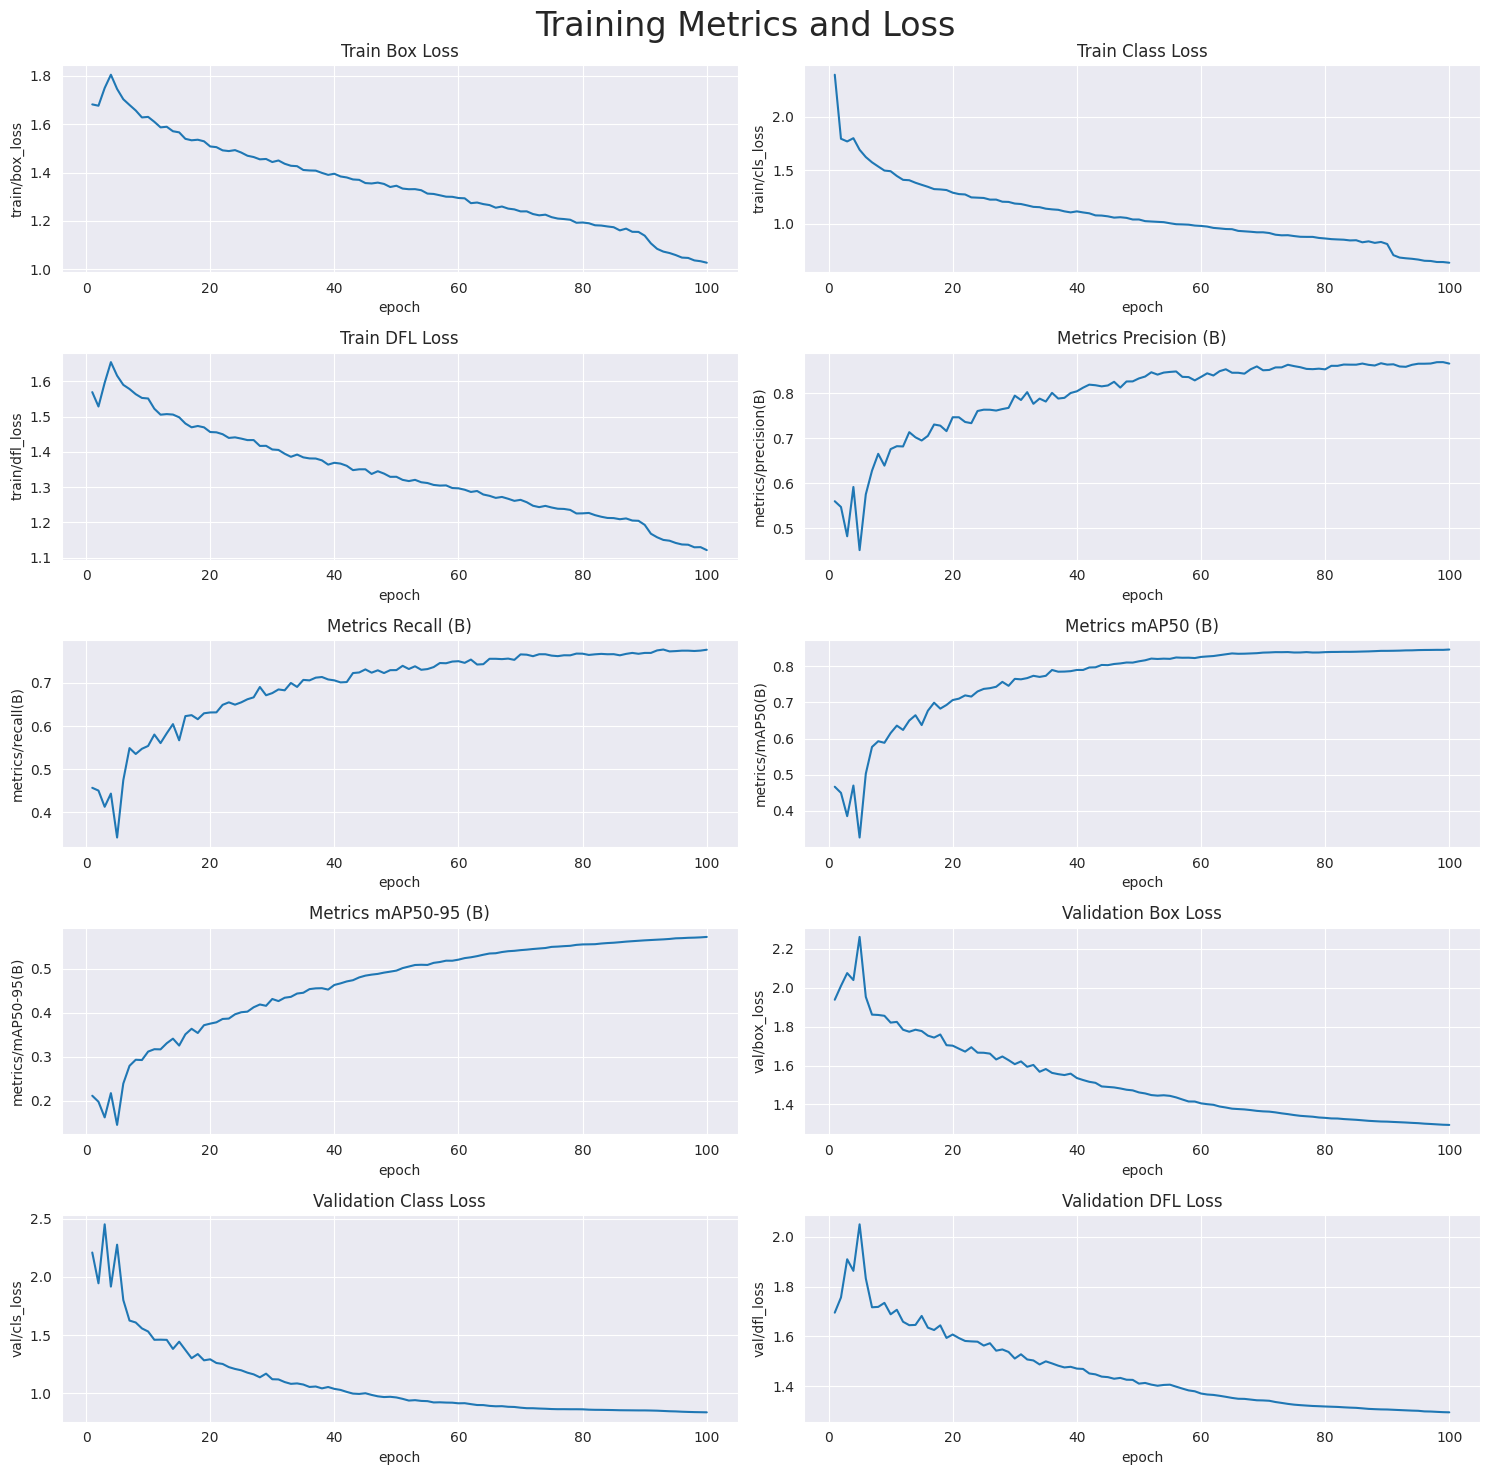

In [9]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Model Evaluation

In [10]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.34 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/pothole-dataset/test/labels... 891 images, 0 backgrounds, 0 corrupt: 100%|██████████| 891/891 [00:04<00:00, 222.05it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/test is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 2171. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:06<00:00,  8.36it/s]


                   all        891       2171      0.836      0.797      0.847      0.608
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val


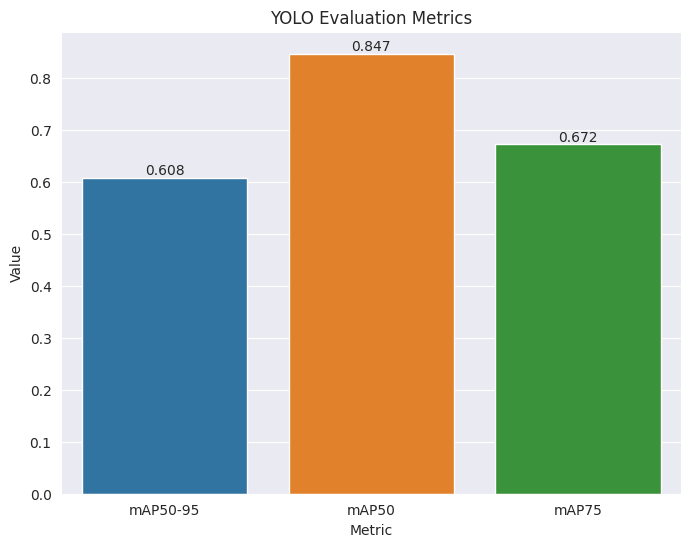

In [11]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()


## Confusion Matrix

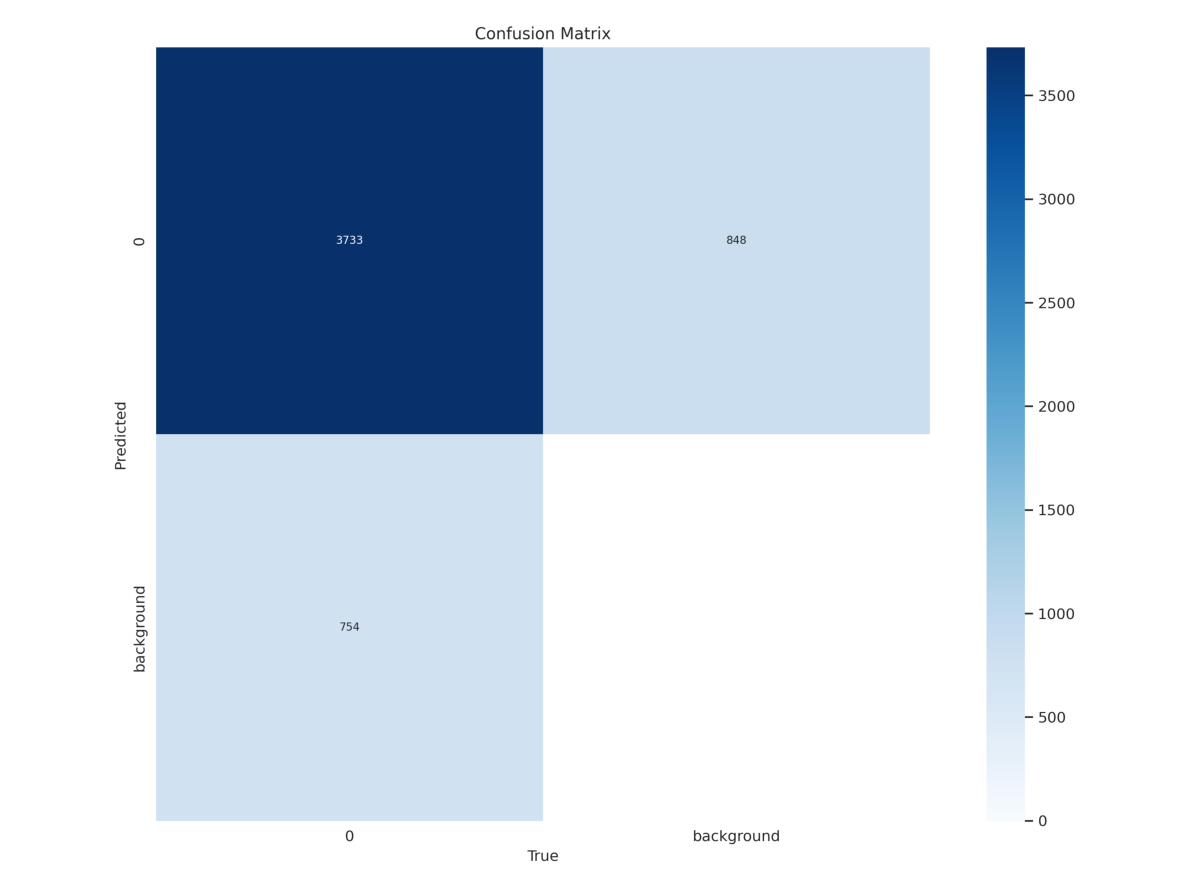

In [12]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# Making Predictions on Test Images

In [13]:
# Function to perform ship detections
def pothole_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 3 0s, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1

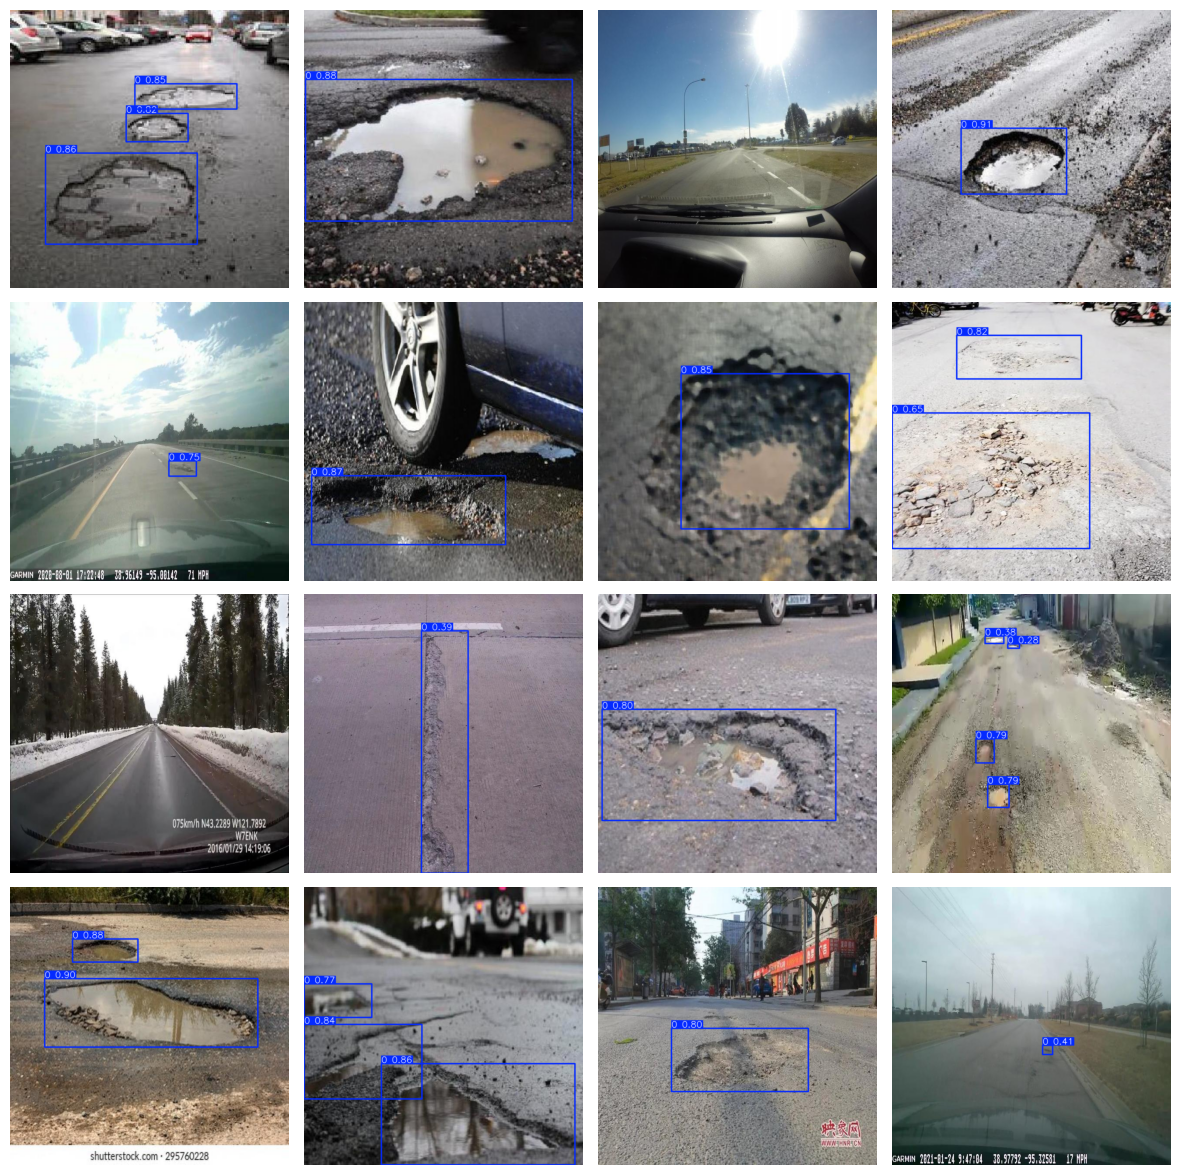

In [14]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/pothole-dataset/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = pothole_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Export model

In [15]:
    # Save model
    torch.save(model, "pothole_" + modelName)

    # Export model 
    model.export(format="onnx")

    # Export model
    model.export(format="engine")

NameError: name 'modelName' is not defined

# Download train results and model

In [ ]:
# zip the test results folder
!zip -r yolo_training_results.zip /kaggle/working/runs

In [ ]:
!mkdir /kaggle/output/
!mv yolo_training_results.zip /kaggle/output/